# IMPORT DATA AND LIBRARIES

In [ ]:
!pip install tensorflow==2.16.0rc0
!PYTHONHASHSEED=0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import pandas as pd
import random as python_random
import os
import shutil
import glob

# Import TensorFlow/Keras
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Activation, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, Dropout, Activation, BatchNormalization, GroupNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import tensorflow.keras.backend as K


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# File's path on Google Drive
drive_zip_path = '/content/gdrive/MyDrive/DL_Project/data/128.zip'
local_extract_path = '/content/Training_Data'
os.makedirs(local_extract_path, exist_ok=True
            )
# Unzip the ZIP file in the local directory
with zipfile.ZipFile(drive_zip_path, 'r') as zip_ref:
    zip_ref.extractall(local_extract_path)

print("Decompressione completata.")

Decompressione completata.


In [ ]:
train_img_dir = "/content/Training_Data/X_train/"
train_mask_dir = "/content/Training_Data/Y_train/"
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_dir = "/content/Training_Data/X_val/"
val_mask_dir = "/content/Training_Data/Y_val/"
val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

# DATA GENERATOR

In [ ]:
# Function to load images from a given directory and list of image file names
def load_img(img_dir, img_list):
    images = []  # Initialize an empty list to store the images
    for image_name in img_list:  # Loop through each image name in the list
        if image_name.split('.')[-1] == 'npy':  # Check if the file is a .npy file
            volume = np.load(img_dir + image_name)  # Load the .npy file as a numpy array
            # Extract 128 images along the third axis (z-axis) from each volume
            for j in range(volume.shape[2]):
                images.append(volume[:, :, j, :])  # Append each slice to the images list
    images = np.array(images)  # Convert the list of images to a numpy array
    return images  # Return the numpy array of images

In [ ]:
# Generator function to load and yield image and mask batches
def image_loader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)  # Get the length of the image list
    N = int(batch_size / 128)

    while True:  # Infinite loop to keep yielding batches

        for i in range(0, L, N):  # Iterate through the image list in steps of 2
            if i + (N-1) < L:  # Check if there are at least two more volumes to load
                img = load_img(img_dir, img_list[i:(i+N)])  # Load images from two volumes
                mask = load_img(mask_dir, mask_list[i:(i+N)])  # Load corresponding masks

                # Combine images and masks into a list of tuples and shuffle them
                combined = list(zip(img, mask))
                np.random.shuffle(combined)
                img[:], mask[:] = zip(*combined)  # Unzip the shuffled list back into images and masks

                yield (img, mask)  # Yield the shuffled images and masks as a batch
            else:
                # Handle the case where there is an odd number of volumes
                img = load_img(img_dir, img_list[i:L])  # Load images from the last volume
                mask = load_img(mask_dir, mask_list[i:L])  # Load corresponding masks

                # Combine images and masks into a list of tuples and shuffle them
                combined = list(zip(img, mask))
                np.random.shuffle(combined)
                img[:], mask[:] = zip(*combined)  # Unzip the shuffled list back into images and masks

                yield (img, mask)  # Yield the shuffled images and masks as a batch

# FIXED PARAMETERS

In [ ]:
#Compute weight of classes

columns = ['0','1', '2', '3']
df = pd.DataFrame(columns = columns)
train_mask_list = sorted(glob.glob('/content/Training_Data/Y_train/*.npy'))
for img in range(len(train_mask_list)):

  temp_image=np.load(train_mask_list[img])
  temp_image = np.argmax(temp_image, axis=3)
  val, counts = np.unique(temp_image, return_counts=True)

  conts_dict = {str(i): 0 for i in range(4)}
  for v, c in zip(val, counts):
    conts_dict[str(v)] = c

  row_df = pd.DataFrame([conts_dict])

  # Add new count row
  df = pd.concat([df, row_df], ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(wt0, wt1, wt2, wt3)


0.26 8.56 29.69 27.28


In [ ]:
#Define loss function and metrics to use during training
CFC_loss = keras.losses.CategoricalFocalCrossentropy(alpha = [wt0, wt1, wt2, wt3])

IoU_0 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [0])
IoU_1 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [1])
IoU_2 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [2])
IoU_3 = keras.metrics.OneHotIoU(num_classes = 4, target_class_ids = [3])

Mean_IoU = keras.metrics.OneHotMeanIoU(num_classes = 4)

metrics = ["accuracy",  Mean_IoU, IoU_0, IoU_1, IoU_2, IoU_3]

In [ ]:
#Define the optimizer
batch_size = 256

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-4,
    decay_steps  = (len(train_img_list) // 2),
    decay_rate = 0.985)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

# MODEL ARCHITECTURE

In [ ]:
def conv_block_2d(input, n_filters, dropout_rate):
    x = Conv2D(n_filters, 3, padding='same')(input)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(n_filters, 3, padding='same')(x)
    x = Activation('relu')(x)
    return x

def encoder_block_2d(input, num_filters, dropout_rate):
    x = conv_block_2d(input, num_filters, dropout_rate)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block_2d(input, skip_features, num_filters, dropout_rate):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    x = concatenate([x, skip_features])
    x = conv_block_2d(x, num_filters, dropout_rate)
    return x

def build_unet_2d(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block_2d(inputs, 64, 0)
    s2, p2 = encoder_block_2d(p1, 128, 0)
    s3, p3 = encoder_block_2d(p2, 256, 0)
    s4, p4 = encoder_block_2d(p3, 512, 0)

    b1 = conv_block_2d(p4, 1024, 0)

    d1 = decoder_block_2d(b1, s4, 512, 0)
    d2 = decoder_block_2d(d1, s3, 256, 0)
    d3 = decoder_block_2d(d2, s2, 128, 0)
    d4 = decoder_block_2d(d3, s1, 64, 0)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)  # esempio di input_shape 2D
n_classes = 4

model3 = build_unet_2d(input_shape, n_classes)
model3.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)

# TRAIN BASE MODEL (no batch normalization, dropout or regularization)

In [ ]:
train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list) // 2
val_steps_per_epoch = len(val_img_list) // 2

# path to save best model weights
checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_64_base.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',    # Track validation loss
    patience = 10,           # Max number of epochs without improvements
    restore_best_weights = True
)

csv = CSVLogger("/content/gdrive/MyDrive/DL_Project/2Dc_64_base.csv")

In [ ]:
history = model3.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5424 - loss: 0.6484 - one_hot_io_u: 0.2414 - one_hot_io_u_1: 0.1317 - one_hot_io_u_2: 0.0532 - one_hot_io_u_3: 0.0678 - one_hot_mean_io_u: 0.1235
Epoch 1: val_loss improved from inf to 0.47974, saving model to /content/gdrive/MyDrive/DL_Project/2D_64_base.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 258s 835ms/step - accuracy: 0.5431 - loss: 0.6479 - one_hot_io_u: 0.2414 - one_hot_io_u_1: 0.1322 - one_hot_io_u_2: 0.0534 - one_hot_io_u_3: 0.0682 - one_hot_mean_io_u: 0.1238 - val_accuracy: 0.6492 - val_loss: 0.4797 - val_one_hot_io_u: 0.3541 - val_one_hot_io_u_1: 0.1532 - val_one_hot_io_u_2: 0.1599 - val_one_hot_io_u_3: 0.0496 - val_one_hot_mean_io_u: 0.1792
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.7013 - loss: 0.4882 - one_hot_io_u: 0.2983 - one_hot_io_u_1: 0.1872 - one_hot_io_u_2: 0.0909 - one_hot_io_u_3: 0.0895 - one_hot_mean_io_u: 0.1665
Epoch 2: val_loss improved from 0.47974 to 0.47571, saving m

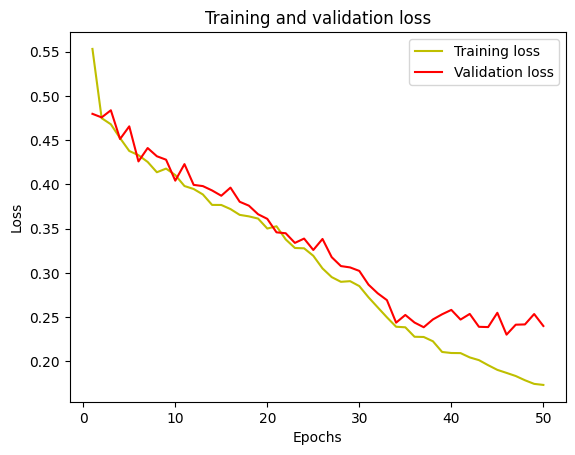

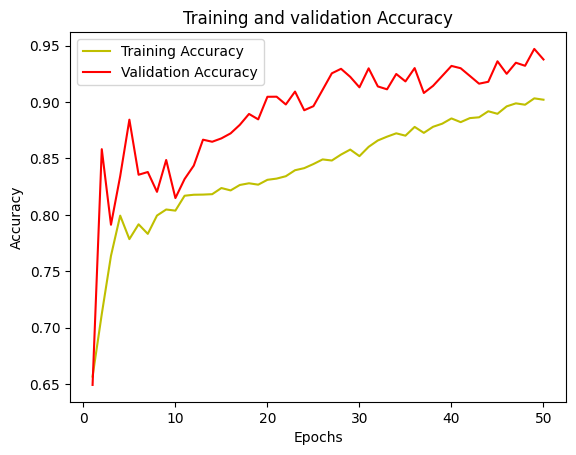

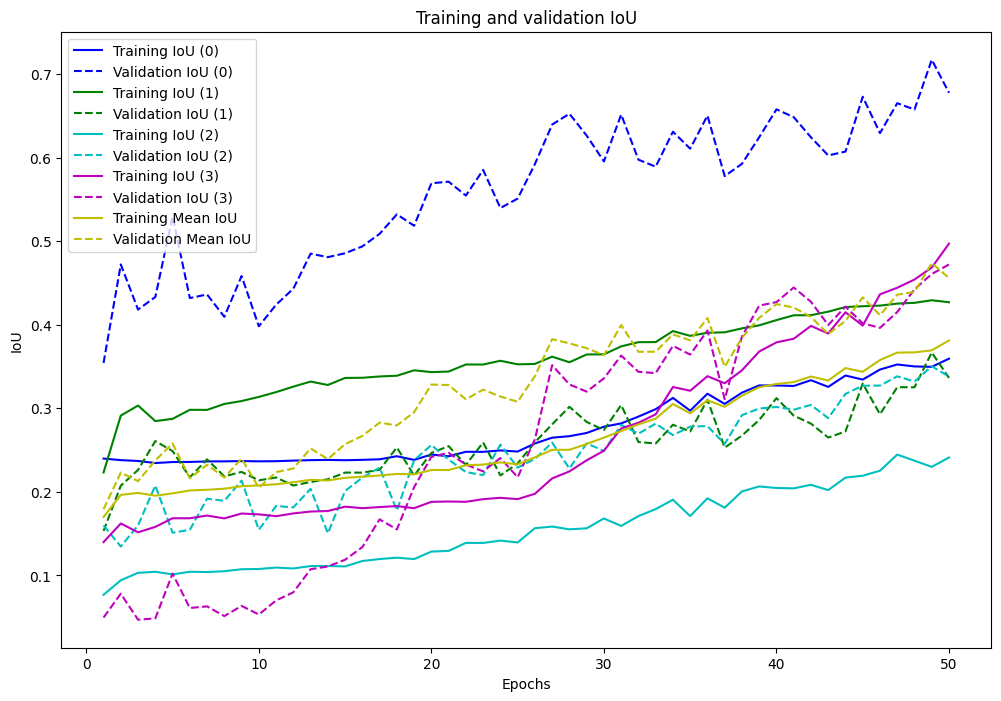

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u']
a2 = history.history['val_one_hot_io_u']
b1 = history.history['one_hot_io_u_1']
b2 = history.history['val_one_hot_io_u_1']
c1 = history.history['one_hot_io_u_2']
c2 = history.history['val_one_hot_io_u_2']
d1 = history.history['one_hot_io_u_3']
d2 = history.history['val_one_hot_io_u_3']
e1 = history.history['one_hot_mean_io_u']
e2 = history.history['val_one_hot_mean_io_u']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
#We try to continue training until epoch 100
history = model3.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    initial_epoch = 50,
                    epochs = 100,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 51/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8904 - loss: 0.2012 - one_hot_io_u: 0.4680 - one_hot_io_u_1: 0.3125 - one_hot_io_u_2: 0.2428 - one_hot_io_u_3: 0.4492 - one_hot_mean_io_u: 0.3681
Epoch 51: val_loss did not improve from 0.23029
169/169 ━━━━━━━━━━━━━━━━━━━━ 102s 607ms/step - accuracy: 0.8904 - loss: 0.2011 - one_hot_io_u: 0.4673 - one_hot_io_u_1: 0.3132 - one_hot_io_u_2: 0.2428 - one_hot_io_u_3: 0.4493 - one_hot_mean_io_u: 0.3682 - val_accuracy: 0.9368 - val_loss: 0.2437 - val_one_hot_io_u: 0.6728 - val_one_hot_io_u_1: 0.3266 - val_one_hot_io_u_2: 0.3249 - val_one_hot_io_u_3: 0.4617 - val_one_hot_mean_io_u: 0.4465
Epoch 52/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8907 - loss: 0.1966 - one_hot_io_u: 0.4688 - one_hot_io_u_1: 0.3112 - one_hot_io_u_2: 0.2371 - one_hot_io_u_3: 0.4499 - one_hot_mean_io_u: 0.3668
Epoch 52: val_loss improved from 0.23029 to 0.22648, saving model to /content/gdrive/MyDrive/DL_Project/2D_64_base.h5.keras
169

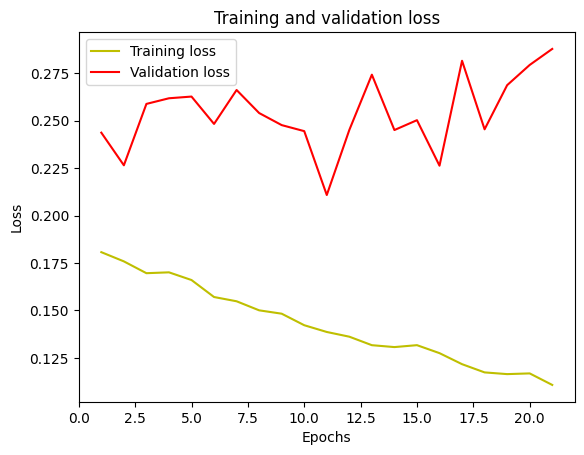

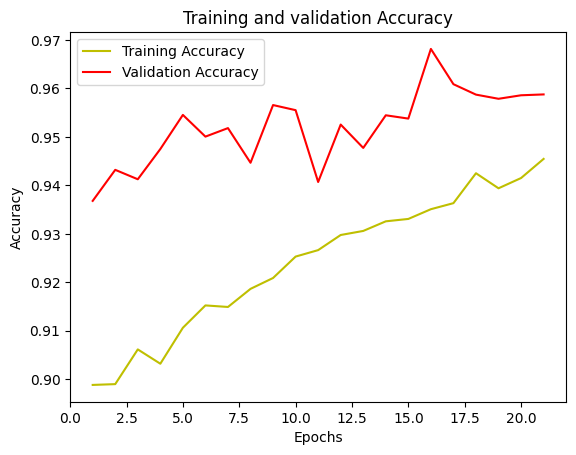

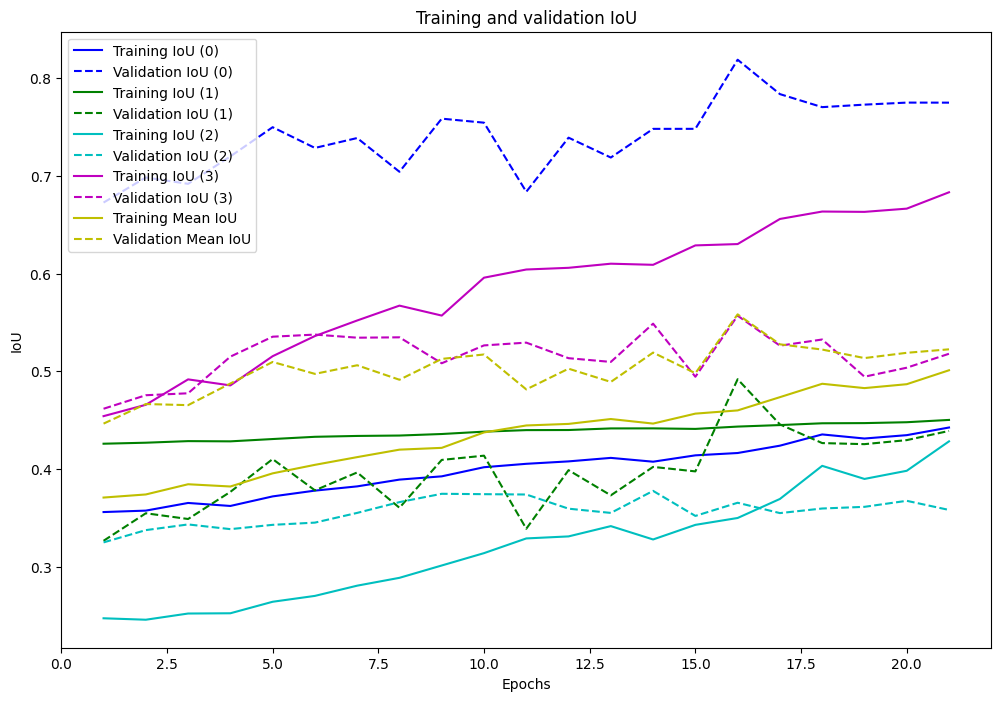

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u']
a2 = history.history['val_one_hot_io_u']
b1 = history.history['one_hot_io_u_1']
b2 = history.history['val_one_hot_io_u_1']
c1 = history.history['one_hot_io_u_2']
c2 = history.history['val_one_hot_io_u_2']
d1 = history.history['one_hot_io_u_3']
d2 = history.history['val_one_hot_io_u_3']
e1 = history.history['one_hot_mean_io_u']
e2 = history.history['val_one_hot_mean_io_u']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
model3.save('/content/gdrive/MyDrive/DL_Project/2D_Unet/64_Base.keras')

# ADD BATCH NORMALIZATION

In [ ]:
#Define the optimizer
batch_size = 256

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-4,
    decay_steps  = (len(train_img_list) // 4),
    decay_rate = 0.985)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

In [ ]:
#Modify convolutional block adding batch normalization
def conv_block_2d(input, n_filters, dropout_rate):
    x = Conv2D(n_filters, 3, padding='same')(input)
    X = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(n_filters, 3, padding='same')(x)
    X = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
#Compile new model
model2 = build_unet_2d(input_shape, n_classes)
model2.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)
model2.summary()

Model: "2D_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 128, 128, 64)         2368      ['input_3[0][0]']             
                                                                                                  
 activation_36 (Activation)  (None, 128, 128, 64)         0         ['conv2d_38[0][0]']           
                                                                                                  
 dropout_18 (Dropout)        (None, 128, 128, 64)         0         ['activation_36[0][0]']       
                                                                                           

In [ ]:
train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list) // 2
val_steps_per_epoch = len(val_img_list) // 2

# path to save best model weights
checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_UNet_64_BatchNorm.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',    # Track validation loss
    patience = 10,           # Max number of epochs without improvements
    restore_best_weights = True
)

csv = CSVLogger("/content/gdrive/MyDrive/DL_Project/history64_BatchNorm.csv")

In [ ]:
history = model2.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 30,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.7628 - one_hot_mean_io_u: 0.2584 - one_hot_io_u: 0.7692 - one_hot_io_u_1: 0.1172 - one_hot_io_u_2: 0.0790 - one_hot_io_u_3: 0.0683
Epoch 1: val_loss improved from inf to 0.46458, saving model to /content/gdrive/MyDrive/DL_Project/2D_UNet_64_BatchNorm.h5.keras
169/169 [==============================] - 109s 648ms/step - loss: 0.4610 - accuracy: 0.7628 - one_hot_mean_io_u: 0.2584 - one_hot_io_u: 0.7692 - one_hot_io_u_1: 0.1172 - one_hot_io_u_2: 0.0790 - one_hot_io_u_3: 0.0683 - val_loss: 0.4646 - val_accuracy: 0.8003 - val_one_hot_mean_io_u: 0.3118 - val_one_hot_io_u: 0.8105 - val_one_hot_io_u_1: 0.2102 - val_one_hot_io_u_2: 0.1796 - val_one_hot_io_u_3: 0.0468
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.7918 - one_hot_mean_io_u: 0.2743 - one_hot_io_u: 0.7984 - one_hot_io_u_1: 0.1273 - one_hot_io_u_2: 0.0839 - one_hot_io_u_3: 0.0876
Epoch 2: val_loss im

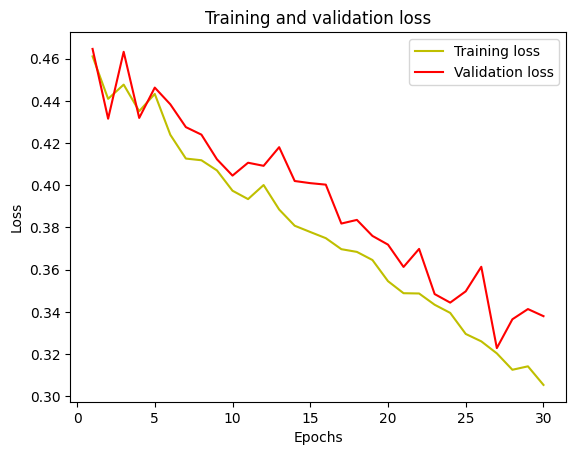

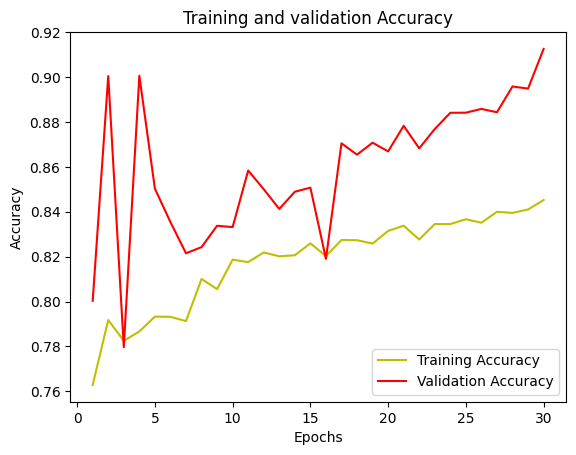

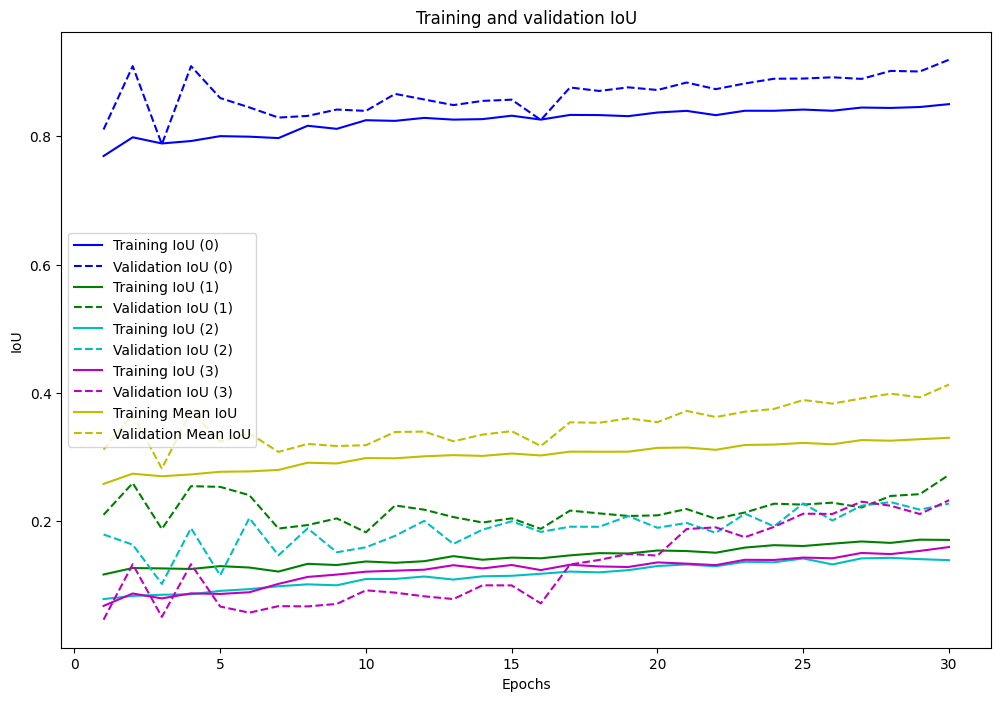

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



a1 = history.history['one_hot_io_u']
a2 = history.history['val_one_hot_io_u']
b1 = history.history['one_hot_io_u_1']
b2 = history.history['val_one_hot_io_u_1']
c1 = history.history['one_hot_io_u_2']
c2 = history.history['val_one_hot_io_u_2']
d1 = history.history['one_hot_io_u_3']
d2 = history.history['val_one_hot_io_u_3']
e1 = history.history['one_hot_mean_io_u']
e2 = history.history['val_one_hot_mean_io_u']

colors = ['b', 'g', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

plt.plot(epochs, a1, color=colors[0], linestyle=line_styles[0], label='Training IoU (0)')
plt.plot(epochs, a2, color=colors[0], linestyle=line_styles[1], label='Validation IoU (0)')
plt.plot(epochs, b1, color=colors[1], linestyle=line_styles[0], label='Training IoU (1)')
plt.plot(epochs, b2, color=colors[1], linestyle=line_styles[1], label='Validation IoU (1)')
plt.plot(epochs, c1, color=colors[2], linestyle=line_styles[0], label='Training IoU (2)')
plt.plot(epochs, c2, color=colors[2], linestyle=line_styles[1], label='Validation IoU (2)')
plt.plot(epochs, d1, color=colors[3], linestyle=line_styles[0], label='Training IoU (3)')
plt.plot(epochs, d2, color=colors[3], linestyle=line_styles[1], label='Validation IoU (3)')
plt.plot(epochs, e1, color=colors[4], linestyle=line_styles[0], label='Training Mean IoU')
plt.plot(epochs, e2, color=colors[4], linestyle=line_styles[1], label='Validation Mean IoU')

plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# ADD BATCH NORM AND 2D SPATIAL DROPOUT

In [ ]:
#Define the optimizer
batch_size = 256

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 5e-4,
    decay_steps  = (len(train_img_list) // 2),
    decay_rate = 0.985)

optim = keras.optimizers.Adam(learning_rate = lr_schedule)

In [ ]:

from tensorflow.keras.layers import SpatialDropout2D

def conv_block_2d(input, n_filters):
    x = Conv2D(n_filters, 3, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout2D(0.3)(x)
    x = Conv2D(n_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block_2d(input, num_filters):
    x = conv_block_2d(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block_2d(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    x = concatenate([x, skip_features])
    x = conv_block_2d(x, num_filters)
    return x

In [ ]:
def build_unet_2d(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block_2d(inputs, 64)
    s2, p2 = encoder_block_2d(p1, 128)
    s3, p3 = encoder_block_2d(p2, 256)
    s4, p4 = encoder_block_2d(p3, 512)

    b1 = conv_block_2d(p4, 1024)

    d1 = decoder_block_2d(b1, s4, 512)
    d2 = decoder_block_2d(d1, s3, 256)
    d3 = decoder_block_2d(d2, s2, 128)
    d4 = decoder_block_2d(d3, s1, 64)

    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs, outputs, name='2D_U-Net')
    return model

input_shape = (128, 128, 4)
n_classes = 4

model4 = build_unet_2d(input_shape, n_classes)
model4.compile(optimizer = optim, loss = CFC_loss, metrics = metrics)

In [ ]:
train_img_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

steps_per_epoch = len(train_img_list) // 2
val_steps_per_epoch = len(val_img_list) // 2

# path to save best model weights
checkpoint_path = "/content/gdrive/MyDrive/DL_Project/2D_64_Complex.h5.keras"

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1
)

early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',    # Track validation loss
    patience = 10,           # Max number of epochs without improvements
    restore_best_weights = True
)

csv = CSVLogger("/content/gdrive/MyDrive/DL_Project/2D_64_Complex.csv")

In [ ]:
history = model4.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_img_datagen,
                    validation_steps = val_steps_per_epoch,
                    callbacks = [checkpoint_callback, early_stopping_callback, csv]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5548 - loss: 0.5922 - one_hot_io_u: 0.2604 - one_hot_io_u_1: 0.3126 - one_hot_io_u_2: 0.0977 - one_hot_io_u_3: 0.1314 - one_hot_mean_io_u: 0.2005
Epoch 1: val_loss improved from inf to 1.05323, saving model to /content/gdrive/MyDrive/DL_Project/2D_64_Complex.h5.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 154s 626ms/step - accuracy: 0.5557 - loss: 0.5913 - one_hot_io_u: 0.2603 - one_hot_io_u_1: 0.3129 - one_hot_io_u_2: 0.0979 - one_hot_io_u_3: 0.1318 - one_hot_mean_io_u: 0.2007 - val_accuracy: 0.9491 - val_loss: 1.0532 - val_one_hot_io_u: 0.6887 - val_one_hot_io_u_1: 0.0201 - val_one_hot_io_u_2: 0.0011 - val_one_hot_io_u_3: 9.4095e-04 - val_one_hot_mean_io_u: 0.1777
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8057 - loss: 0.3805 - one_hot_io_u: 0.3414 - one_hot_io_u_1: 0.2312 - one_hot_io_u_2: 0.0825 - one_hot_io_u_3: 0.1614 - one_hot_mean_io_u: 0.2041
Epoch 2: val_loss improved from 1.05323 to 0.61613, s